In [ ]:
# Importing relevant packages
import os 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 


Welcome to Ido, Roi & Rephael Project.
The project goal is to detect all the distracted drivers based on the drivers pictures, using cnn architectures.
This process will not only detect the distracted drivers, it can show what they have done in many cases and in extreme cases - such as talking on the phone, looking backwards etc.

 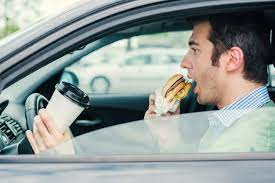

In [ ]:
# To import directly a dataset from kaggle, we used the kaggle API and then created a directory in colab of the dataset images.
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Donwloading Competition dataset by images.
! kaggle competitions download -c state-farm-distracted-driver-detection
! unzip state-farm-distracted-driver-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: imgs/train/c7/img_56636.jpg  
  inflating: imgs/train/c7/img_56661.jpg  
  inflating: imgs/train/c7/img_56699.jpg  
  inflating: imgs/train/c7/img_56717.jpg  
  inflating: imgs/train/c7/img_56724.jpg  
  inflating: imgs/train/c7/img_56768.jpg  
  inflating: imgs/train/c7/img_56779.jpg  
  inflating: imgs/train/c7/img_56849.jpg  
  inflating: imgs/train/c7/img_56899.jpg  
  inflating: imgs/train/c7/img_56938.jpg  
  inflating: imgs/train/c7/img_5706.jpg  
  inflating: imgs/train/c7/img_57076.jpg  
  inflating: imgs/train/c7/img_57122.jpg  
  inflating: imgs/train/c7/img_57137.jpg  
  inflating: imgs/train/c7/img_5715.jpg  
  inflating: imgs/train/c7/img_57278.jpg  
  inflating: imgs/train/c7/img_57321.jpg  
  inflating: imgs/train/c7/img_57345.jpg  
  inflating: imgs/train/c7/img_57355.jpg  
  inflating: imgs/train/c7/img_5741.jpg  
  inflating: imgs/train/c7/img_57433.jpg  
  inflating: imgs/train/c7/img_5753.jpg  
  infla

In [ ]:
# At first lets label our data with explainable labels

images_path = '/content/imgs/train'
classes = [lab for lab in os.listdir(images_path) if not lab.startswith(".")]
classes.sort()

# Changing our labels by the dataset menu description
class_dict = {0 : "safe driving",
              1 : "texting - right",
              2 : "talking on the phone - right",
              3 : "texting - left",
              4 : "talking on the phone - left",
              5 : "operating the radio",
              6 : "drinking",
              7 : "reaching behind",
              8 : "hair and makeup",
              9 : "talking to passenger"}          

[Text(0.5, 1.0, 'Image Classes distribution')]

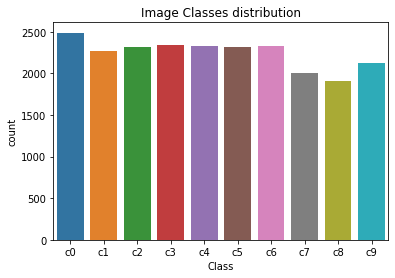

In [ ]:
# at first we would like to check the balance of our dataset - which contains pictures and their labels

classifier = {"Image" : [], "Class" : []}
for cls in classes : 
  images = [image for image in os.listdir(os.path.join(images_path,cls)) if not image.startswith(".")]
  for image in images:
    classifier['Image'].append(image)
    classifier['Class'].append(cls)

class_data = pd.DataFrame(classifier)
plt = sns.countplot(data=class_data,x="Class")
plt.set(title='Image Classes distribution')


 We can see that the class distribution looks balanced. due to imbalance data known problems we checked it.

We will use Image Folder method to transform our image dataset into fitted datasset to use DL methods

In [ ]:
# Importing DL packages
import torch
import torch.nn as nn
import torchvision
from torchvision import models, datasets, transforms
import torch.nn.functional as F

In [ ]:
# Lets initiate first image shape - 400 x 400 with random 5 degrees of image rotation (arbitrary)
transformer = transforms.Compose([transforms.Resize((400,400)),
                                 transforms.RandomRotation(5),
                                 transforms.ToTensor()])


In [ ]:
# creating dataset from imagefoler
dataset = datasets.ImageFolder(root= images_path, transform = transformer)

dataset_len = len(dataset)
train_len = int(0.8*dataset_len)
test_len = dataset_len - train_len

# splitting the dataset to train and test

train_set, test_set = torch.utils.data.random_split(dataset,(train_len,test_len))

# Using train and test loaders 

train_loader = torch.utils.data.DataLoader(train_set,batch_size=4,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=4)

print(f' The dataset length is {dataset_len}')

 The dataset length is 22424


In [ ]:
# What is the shape of the train batch ? 
for i, data in enumerate(train_loader):
  print(data[0].size())
  break

torch.Size([4, 3, 400, 400])


Which means that each batch of size 4 has 3 columns - RGB , and a shape of 400 x 400 tensor that represents the weights.

Lets look on our dataset pictures example

The image label is - c5 - operating the radio




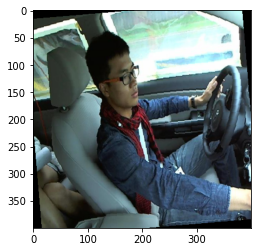

The image label is - c1 - texting - right




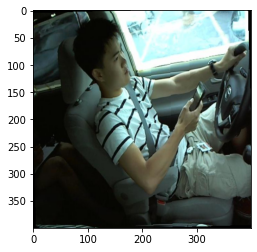

The image label is - c4 - talking on the phone - left




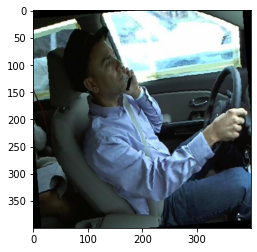

The image label is - c1 - texting - right




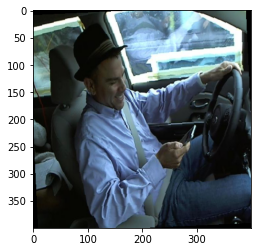

In [ ]:
plt.Figure(figsize=(16,6))
for i in range(4):
  choice = np.random.choice(dataset_len)
  img, c = dataset[choice]
  print(f'The image label is - {classes[c]} - {class_dict[c]}')
  plt.imshow(img.permute(1,2,0))
  print('\n')
  plt.show()

We can see various of classes , images of people talking on the phone, talking to another passenger, drinking, and driving safely.

## Creating a model

At first we will create the benchmark NN model and evaluate it with just 1 conv layer and 3 fully connected layers

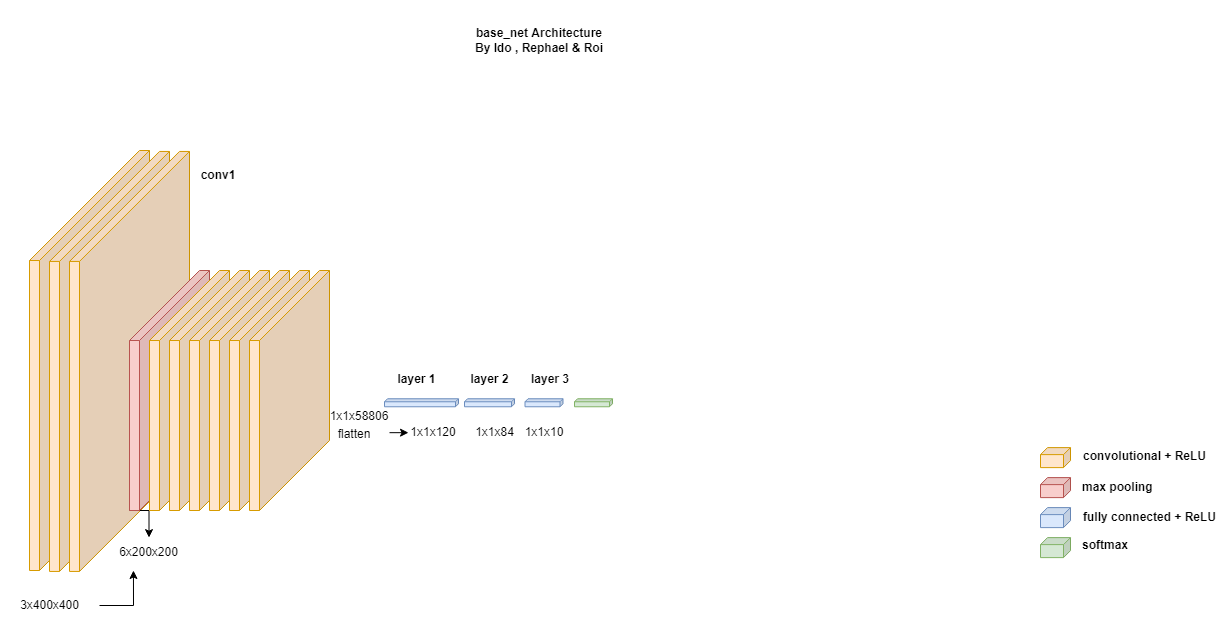

In [ ]:
class base_model(nn.Module):
  # we will initiate our model from nn.Module class, and build cnn model to predict the image class

  def __init__(self):
    super(base_model,self).__init__()
    """ lets decide the convolution window sizes because the picture size is 400x400 colored pixels we will use at the start
    3 windowed channel with 4 output channels """

    self.conv1 = nn.Conv2d(3, 6, 3,2)


    # Now lets initiate the nn layers 
    self.layer1 = nn.Linear(58806,120)
    self.layer2 = nn.Linear(120,84)
    self.layer3 = nn.Linear(84,10) # a final output of probability vector of size 10 for each class

    # defining forward function

  def forward(self,net):
    # lets use the max pooling operation to select the maximum element from the region of the feature map covered by the window to a 2x2 size transformation
    net = F.max_pool2d(F.relu(self.conv1(net)),(2,2))
    # now lets flat our weights matrix to enter to the nn layers
    net = torch.flatten(net,start_dim=1)
    # Applying to the nn
    net = F.relu(self.layer1(net))
    net = F.relu(self.layer2(net))
    net = self.layer3(net)
    return net


In [ ]:
base_net = base_model().cuda()
print(base_net)

base_model(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(2, 2))
  (layer1): Linear(in_features=58806, out_features=120, bias=True)
  (layer2): Linear(in_features=120, out_features=84, bias=True)
  (layer3): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:
def train_model(num_epochs,model,criterion,optimizer):
  acc_lst, loss_lst = [],[]
  for epoch in range(num_epochs):
    loss_epoch = 0.0
    
    for i, data in enumerate(train_loader,0):
      inputs,labels = data
      inputs,labels = inputs.cuda(), labels.cuda()

      # At first we will zero the gradient
      optimizer.zero_grad()

      # Enable Gradient calculations 

      with torch.set_grad_enabled(True):
        outputs = model(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()

      # Updating the loss 
      loss_epoch += loss.item()

    # model Evaluation 
    correct_preds = 0
    total_preds = 0

    with torch.no_grad():
      for i, data in enumerate(test_loader):
        images, true_labels = data
        images, ture_labels = images.cuda(), true_labels.cuda()

        pred_outputs = model(images)

        probabilities, predicted_values = torch.max(pred_outputs,1)
        total_preds += true_labels.size(0)
        correct_preds += (predicted_values.cuda() == true_labels.cuda()).sum().item()
      
    loss_lst.append(loss_epoch),
    acc_lst.append(100 * correct_preds / total_preds)
    print("Epoch Number - %d, Loss is : %.3f" % (epoch + 1, loss_epoch/ len(train_loader)))
    print("Accuracy of the model on test set:  %d %%" % (100 * correct_preds / total_preds))
  
  return model, acc_lst, loss_lst




In [ ]:
# Setting optimizer and loss criterion
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(base_net.parameters(),lr=0.001)

In [ ]:
base_model_sgd, acc_base_model, loss_base_model = train_model(5,base_net, criterion, optimizer)
# It takes around 5 mins per epoch to complete the optimization :)

Epoch Number - 1, Loss is : 1.939
Accuracy of the model on test set:  62 %
Epoch Number - 2, Loss is : 1.002
Accuracy of the model on test set:  70 %
Epoch Number - 3, Loss is : 0.577
Accuracy of the model on test set:  88 %
Epoch Number - 4, Loss is : 0.377
Accuracy of the model on test set:  90 %
Epoch Number - 5, Loss is : 0.285
Accuracy of the model on test set:  82 %


Now we would like to increase the convolutional layers to understand the impact on accuracy , we will create first model with 3 conv layers and 3 fc layers

In [ ]:
class first_model(nn.Module):
  # we will initiate our model from nn.Module class, and build cnn model to predict the image class

  def __init__(self):
    super(first_model,self).__init__()
    """ lets decide the convolution window sizes because the picture size is 400x400 colored pixels we will use at the start
    3 windowed channel with 4 output channels """

    self.conv1 = nn.Conv2d(3, 6, 3,2)
    """In the second convolution window, we will expand our window to size of 16"""
    self.conv2 = nn.Conv2d(6, 16, 3, 2)
    self.conv3 = nn.Conv2d(16, 26, 3, 2)

    # Now lets initiate the nn layers 
    self.layer1 = nn.Linear(650,120)
    self.layer2 = nn.Linear(120,84)
    self.layer3 = nn.Linear(84,10) # a final output of probability vector of size 10 for each class

    # defining forward function

  def forward(self,net):
    # lets use the max pooling operation to select the maximum element from the region of the feature map covered by the window to a 2x2 size transformation
    net = F.max_pool2d(F.relu(self.conv1(net)),(2,2))
    net = F.max_pool2d(F.relu(self.conv2(net)),2)
    net = F.max_pool2d(F.relu(self.conv3(net)),2)
    # now lets flat our weights matrix to enter to the nn layers
    net = torch.flatten(net,start_dim=1)
    # Applying to the nn
    net = F.relu(self.layer1(net))
    net = F.relu(self.layer2(net))
    net = self.layer3(net)
    return net




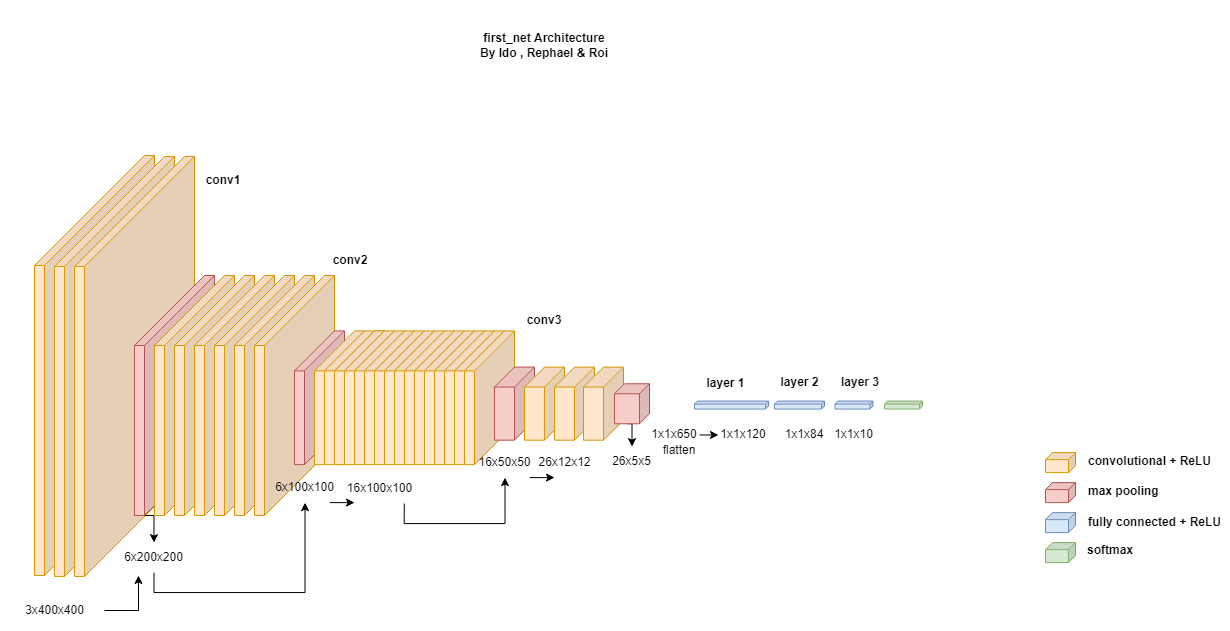

Initializing the neural network

In [ ]:
first_net = first_model().cuda()
print(first_net)

first_model(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(2, 2))
  (conv3): Conv2d(16, 26, kernel_size=(3, 3), stride=(2, 2))
  (layer1): Linear(in_features=650, out_features=120, bias=True)
  (layer2): Linear(in_features=120, out_features=84, bias=True)
  (layer3): Linear(in_features=84, out_features=10, bias=True)
)


Now we will build the fit function to optimize our model 

In [ ]:
# Setting optimizer and loss criterion
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(first_net.parameters(),lr=0.001,momentum=0.9)

In [ ]:
model1_sgd, acc_sgd_model1, loss_sgd_model1 = train_model(5,first_net, criterion, optimizer)
# It takes around 5 mins per epoch to complete the optimization :)

Epoch Number - 1, Loss is : 2.301
Accuracy of the model on test set:  10 %
Epoch Number - 2, Loss is : 2.186
Accuracy of the model on test set:  33 %
Epoch Number - 3, Loss is : 1.113
Accuracy of the model on test set:  78 %
Epoch Number - 4, Loss is : 0.461
Accuracy of the model on test set:  85 %
Epoch Number - 5, Loss is : 0.284
Accuracy of the model on test set:  91 %


So we found out that our learning process is very extreme, lets find out what the results will be with another optimizer and maybe it is related to that.

In [ ]:
# Initializing again the model - this time different optimizer
first_net = first_model().cuda()
optimizer = torch.optim.Adam(first_net.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()
model1_adam, acc_adam_model1, loss_adam_model1 = train_model(5,first_net,criterion,optimizer)

Epoch Number - 1, Loss is : 1.266
Accuracy of the model on test set:  81 %
Epoch Number - 2, Loss is : 0.354
Accuracy of the model on test set:  88 %
Epoch Number - 3, Loss is : 0.226
Accuracy of the model on test set:  94 %
Epoch Number - 4, Loss is : 0.166
Accuracy of the model on test set:  94 %
Epoch Number - 5, Loss is : 0.141
Accuracy of the model on test set:  95 %


We can see that using adam optimizer stabeling our model, 
making the accuracy score start from 80% to 95% - we will continue using **adam** optimizer

Using avg pooling rather than max pooling

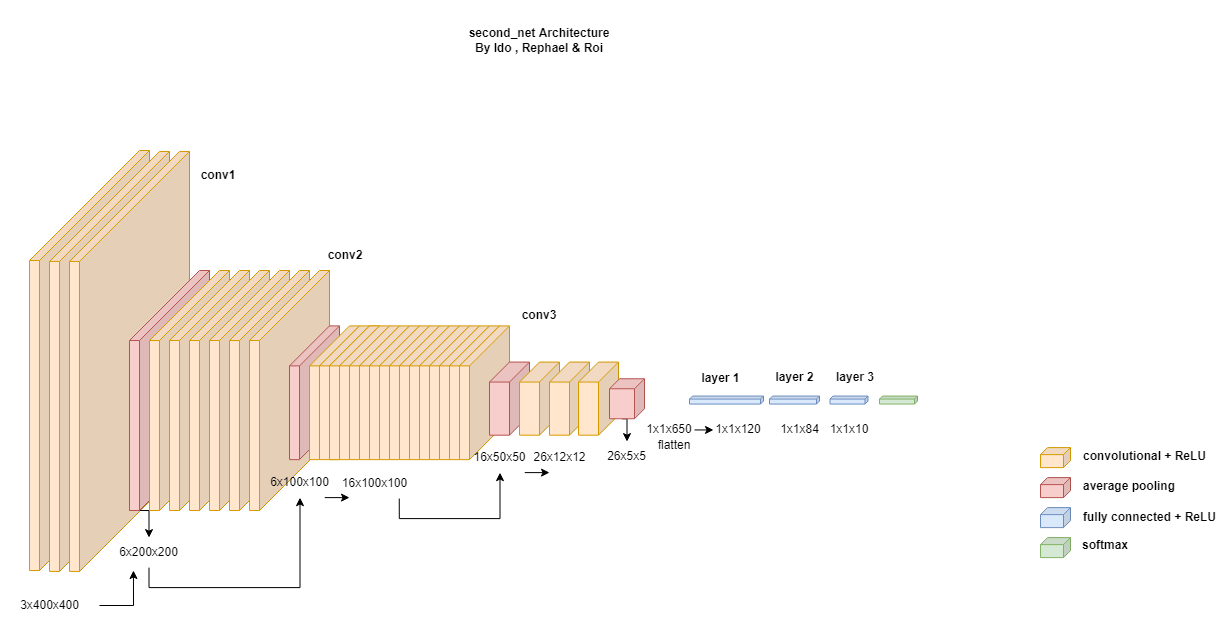

In [ ]:
class second_model(nn.Module):
  # we will initiate our model from nn.Module class, and build cnn model to predict the image class

  def __init__(self):
    super(second_model,self).__init__()
    """ lets decide the convolution window sizes because the picture size is 400x400 colored pixels we will use at the start
    3 windowed channel with 4 output channels """

    self.conv1 = nn.Conv2d(3, 6, 3,2)
    """In the second convolution window, we will expand our window to size of 25"""
    self.conv2 = nn.Conv2d(6, 16, 3, 2)
    self.conv3 = nn.Conv2d(16, 26, 3, 2)

    # Now lets initiate the nn layers 
    self.layer1 = nn.Linear(650,120)
    self.layer2 = nn.Linear(120,84)
    self.layer3 = nn.Linear(84,10) # a final output of probability vector of size 10 for each class

    # defining forward function

  def forward(self,net):
    # lets use the avg pooling operation to select the average element from the region of the feature map covered by the window to a 2x2 size transformation
    net = F.avg_pool2d(F.relu(self.conv1(net)),(2,2))
    net = F.avg_pool2d(F.relu(self.conv2(net)),2)
    net = F.avg_pool2d(F.relu(self.conv3(net)),2)
    # now lets flat our weights matrix to enter to the nn layers
    net = torch.flatten(net,start_dim=1)
    # Applying to the nn
    net = F.relu(self.layer1(net))
    net = F.relu(self.layer2(net))
    net = self.layer3(net)
    return net


In [ ]:
second_net = second_model().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(second_net.parameters(),lr=0.001)
model2_adam, acc_adam_model2, loss_adam_model2 = train_model(5,second_net,criterion,optimizer)

Epoch Number - 1, Loss is : 1.262
Accuracy of the model on test set:  84 %
Epoch Number - 2, Loss is : 0.376
Accuracy of the model on test set:  91 %
Epoch Number - 3, Loss is : 0.234
Accuracy of the model on test set:  93 %
Epoch Number - 4, Loss is : 0.185
Accuracy of the model on test set:  94 %
Epoch Number - 5, Loss is : 0.145
Accuracy of the model on test set:  93 %


We can see that there is a slight differenece between the avg pooling to max pooling, but max pooling is still better option

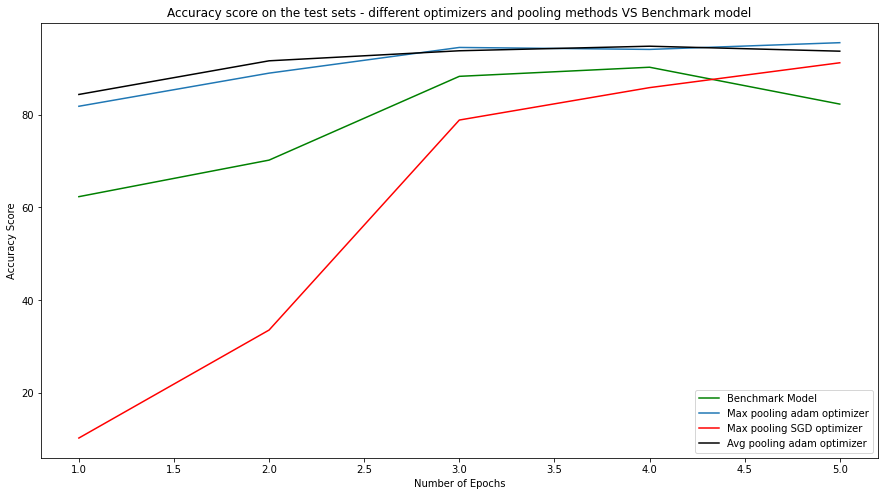

In [ ]:
plt.figure(figsize = (15,8))
plt.plot(range(1,6),acc_base_model,color='green')
plt.plot(range(1,6),acc_adam_model1)
plt.plot(range(1,6),acc_sgd_model1,color='red')
plt.plot(range(1,6),acc_adam_model2,color='black')
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy Score")
plt.title("Accuracy score on the test sets - different optimizers and pooling methods VS Benchmark model")
plt.legend(["Benchmark Model","Max pooling adam optimizer","Max pooling SGD optimizer","Avg pooling adam optimizer"])